# LAB: Attention

Paper: https://arxiv.org/pdf/1502.03044.pdf

**Task:** Implement the paper: Show, Attend and Tell: Neural Image Caption Generation with Visual Attention
using soft attention on this dataset. The train, validation, and test samples are stored in each folder
separately. The captions are stored in .pkl files within each folder. The .pkl file is a dictionary which takes image name with extension as the key and has value as a list of five captions associated with the current image.


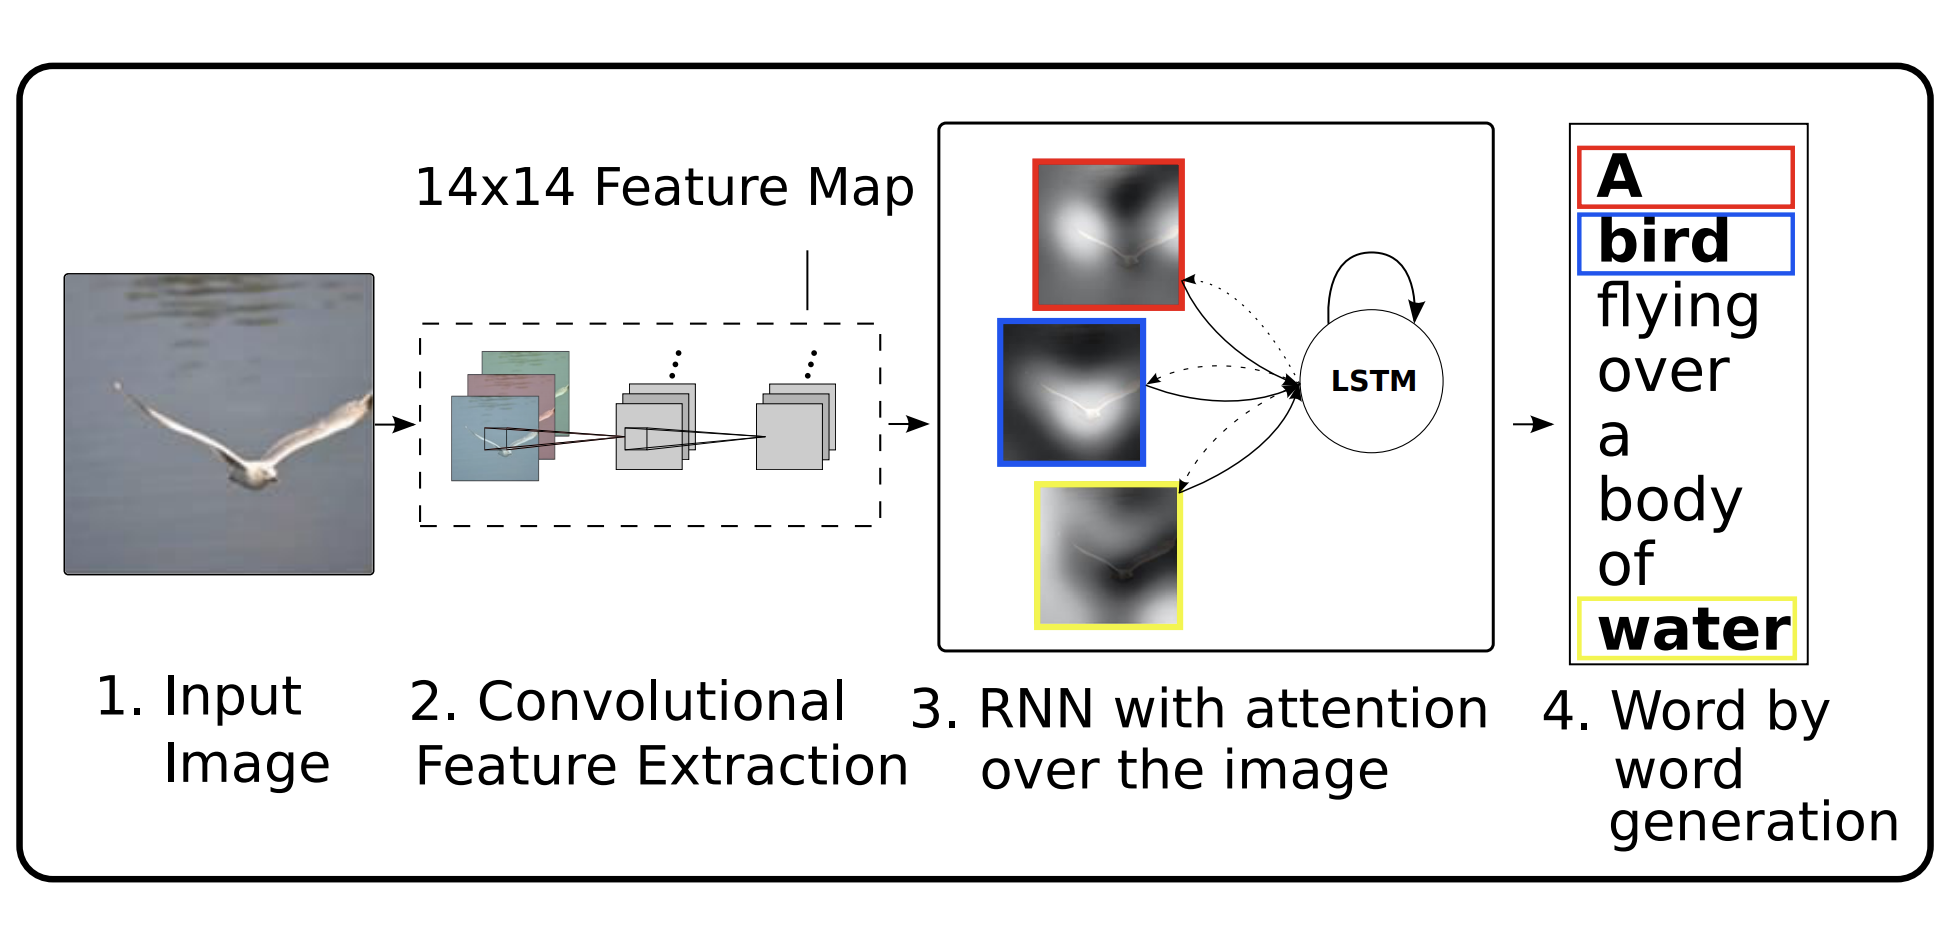

In [ ]:
! pip install -U nltk

     |████████████████████████████████| 1.5 MB 9.5 MB/s 
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/IIIT_DATA/PGDDSAI/A4/q1")
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from models import Encoder, DecoderWithAttention
from datasets import *
from utils import *
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score

In [ ]:
# Data parameters
data_folder = '/content/drive/MyDrive/IIIT_DATA/PGDDSAI/A4/q1/caption_data/'  # folder with data files saved by create_input_files.py
data_name = 'flickr8k_5_cap_per_img_5_min_word_freq'  # base name shared by data files

# Model parameters
emb_dim = 512  # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
# device = torch.device("cpu")
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

# Training parameters
start_epoch = 0
epochs = 120  # number of epochs to train for (if early stopping is not triggered)
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
batch_size = 32
workers = 1  # for data-loading; right now, only 1 works with h5py
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
best_bleu4 = 0.  # BLEU-4 score right now
print_freq = 1000  # print training/validation stats every __ batches
fine_tune_encoder = False  # fine-tune encoder?
checkpoint = None  # path to checkpoint, None if none

In [ ]:
def main():
    """
    Training and validation.
    """

    global best_bleu4, epochs_since_improvement, checkpoint, start_epoch, fine_tune_encoder, data_name, word_map

    # Read word map
    word_map_file = os.path.join(data_folder, 'WORDMAP_' + data_name + '.json')
    with open(word_map_file, 'r') as j:
        word_map = json.load(j)

    # Initialize / load checkpoint
    if checkpoint is None:
        decoder = DecoderWithAttention(attention_dim=attention_dim,
                                       embed_dim=emb_dim,
                                       decoder_dim=decoder_dim,
                                       vocab_size=len(word_map),
                                       dropout=dropout)
        decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
        encoder = Encoder()
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None

    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        epochs_since_improvement = checkpoint['epochs_since_improvement']
        best_bleu4 = checkpoint['bleu-4']
        decoder = checkpoint['decoder']
        decoder_optimizer = checkpoint['decoder_optimizer']
        encoder = checkpoint['encoder']
        encoder_optimizer = checkpoint['encoder_optimizer']
        if fine_tune_encoder is True and encoder_optimizer is None:
            encoder.fine_tune(fine_tune_encoder)
            encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                                 lr=encoder_lr)

    with open(word_map_file, 'r') as j:
      word_map = json.load(j)
    rev_word_map = {v: k for k, v in word_map.items()}
    # Move to GPU, if available
    decoder = decoder.to(device)
    encoder = encoder.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss().to(device)

    # Custom dataloaders
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    train_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'TRAIN', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'VAL', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    # Epochs
    for epoch in range(start_epoch, epochs):

        # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
        if epochs_since_improvement == 20:
            break
        if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
            adjust_learning_rate(decoder_optimizer, 0.8)
            if fine_tune_encoder:
                adjust_learning_rate(encoder_optimizer, 0.8)

        # One epoch's training
        train(train_loader=train_loader,
              encoder=encoder,
              decoder=decoder,
              criterion=criterion,
              encoder_optimizer=encoder_optimizer,
              decoder_optimizer=decoder_optimizer,
              epoch=epoch)

        # One epoch's validation
        recent_bleu4 = validate(val_loader=val_loader,
                                encoder=encoder,
                                decoder=decoder,
                                criterion=criterion)

        # Check if there was an improvement
        is_best = recent_bleu4 > best_bleu4
        best_bleu4 = max(recent_bleu4, best_bleu4)
        if not is_best:
            epochs_since_improvement += 1
        else:
            epochs_since_improvement = 0

        # Save checkpoint
        save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                        decoder_optimizer, recent_bleu4, is_best)


def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    """
    Performs one epoch's training.

    :param train_loader: DataLoader for training data
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :param encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
    :param decoder_optimizer: optimizer to update decoder's weights
    :param epoch: epoch number
    """

    decoder.train()  # train mode (dropout and batchnorm is used)
    encoder.train()

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss (per word decoded)
    top5accs = AverageMeter()  # top5 accuracy

    start = time.time()

    # Batches
    for i, (imgs, caps, caplens) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop.
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        scores, *_ = pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets, *_ = pack_padded_sequence(targets, decode_lengths, batch_first=True)

        # Calculate loss
        loss = criterion(scores, targets)

        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Keep track of metrics
        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        # if i % print_freq == 0:
        #     print('Epoch: [{0}][{1}/{2}]\t'
        #           'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
        #           'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
        #           'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
        #           'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
        #                                                                   batch_time=batch_time,
        #                                                                   data_time=data_time, loss=losses,
        #                                                                   top5=top5accs))
    print("Epoch: {}, Loss: {}".format(epoch, losses.val))


def validate(val_loader, encoder, decoder, criterion):
    """
    Performs one epoch's validation.

    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()
    hypotheses_sent = list()
    references_sent = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation to avoid CUDA memory error
    # solves the issue #57
    with torch.no_grad():
        # Batches
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores, *_ = pack_padded_sequence(scores, decode_lengths, batch_first=True)
            targets, *_ = pack_padded_sequence(targets, decode_lengths, batch_first=True)

            # Calculate loss
            loss = criterion(scores, targets)

            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            # if i % print_freq == 0:
            #     print('Validation: [{0}/{1}]\t'
            #           'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            #           'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
            #           'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
            #                                                                     loss=losses, top5=top5accs))

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            allcaps = allcaps[sort_ind]  # because images were sorted in the decoder
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))  # remove <start> and pads
                #references_sent.append(img_caps)
                references.append(img_captions)

            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)
            #words = [rev_word_map[ind] for ind in [w for w in preds if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}]]
            #hypotheses_sent.append(" ".join(words))
            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)
        bleu3 = corpus_bleu(references, hypotheses,(1./3., 1./3., 1./3.,0))
        bleu2 = corpus_bleu(references, hypotheses,(1./2., 1./2.,0,0))
        bleu1 = corpus_bleu(references, hypotheses,(1.,0,0,0))
        # meteor = meteor_score(references, hypotheses_sent)

        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu4}, BLEU-3 - {bleu3}, BLEU-2 - {bleu2}, BLEU-1 - {bleu1}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu4=bleu4,
                bleu1=bleu1,
                bleu2=bleu2,
                bleu3=bleu3
                ))

    return bleu4

In [ ]:
if __name__ == '__main__':
    main()

Epoch: 0, Loss: 4.252184867858887

 * LOSS - 4.173, TOP-5 ACCURACY - 61.828, BLEU-4 - 0.11777165466192817, BLEU-3 - 0.21116301096448475, BLEU-2 - 0.3774712333934464, BLEU-1 - 0.6173388111008636

Epoch: 1, Loss: 3.915578603744507

 * LOSS - 3.905, TOP-5 ACCURACY - 65.312, BLEU-4 - 0.13575719485762813, BLEU-3 - 0.23316776179945684, BLEU-2 - 0.398409738965873, BLEU-1 - 0.6327324557726167

Epoch: 2, Loss: 3.4588255882263184

 * LOSS - 3.787, TOP-5 ACCURACY - 66.905, BLEU-4 - 0.14333158455954806, BLEU-3 - 0.24268661399617203, BLEU-2 - 0.4072800351642585, BLEU-1 - 0.6405634275173975

Epoch: 3, Loss: 3.441675901412964

 * LOSS - 3.729, TOP-5 ACCURACY - 67.955, BLEU-4 - 0.1478315507805844, BLEU-3 - 0.24786122289710155, BLEU-2 - 0.4139409255096192, BLEU-1 - 0.644956820659009

Epoch: 4, Loss: 3.2072300910949707

 * LOSS - 3.696, TOP-5 ACCURACY - 68.295, BLEU-4 - 0.15396529905203613, BLEU-3 - 0.25420214474582303, BLEU-2 - 0.4170316604797698, BLEU-1 - 0.6459461725496772

Epoch: 5, Loss: 3.01763701

In [ ]:
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from datasets import *
from utils import *
from nltk.translate.bleu_score import corpus_bleu
import torch.nn.functional as F
from tqdm import tqdm

# Parameters
checkpoint_file = '/content/BEST_checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pth.tar'  # model checkpoint
word_map_file = '/content/drive/MyDrive/IIIT_DATA/PGDDSAI/A4/q1/caption_data/WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json'  # word map, ensure it's the same the data was encoded with and the model was trained with
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

# Load model
checkpoint = torch.load(checkpoint_file)
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

# Load word map (word2ix)
with open(word_map_file, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}
vocab_size = len(word_map)

# Normalization transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
with open(word_map_file, 'r') as j:
      word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}

In [ ]:
def evaluate(beam_size):
    """
    Evaluation

    :param beam_size: beam size at which to generate captions for evaluation
    :return: BLEU-4 score
    """
    # DataLoader
    loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'TEST', transform=transforms.Compose([normalize])),
        batch_size=1, shuffle=True, num_workers=1, pin_memory=True)

    # TODO: Batched Beam Search
    # Therefore, do not use a batch_size greater than 1 - IMPORTANT!

    # Lists to store references (true captions), and hypothesis (prediction) for each image
    # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
    # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]
    references = list()
    hypotheses = list()

    # For each image
    count = 0
    for i, (image, caps, caplens, allcaps) in enumerate(
            tqdm(loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):

        k = beam_size
        count+=1
        # Move to GPU device, if available
        image = image.to(device)  # (1, 3, 256, 256)

        # Encode
        encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
        enc_image_size = encoder_out.size(1)
        encoder_dim = encoder_out.size(3)

        # Flatten encoding
        encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # We'll treat the problem as having a batch size of k
        encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

        # Tensor to store top k previous words at each step; now they're just <start>
        k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

        # Tensor to store top k sequences; now they're just <start>
        seqs = k_prev_words  # (k, 1)

        # Tensor to store top k sequences' scores; now they're just 0
        top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

        # Lists to store completed sequences and scores
        complete_seqs = list()
        complete_seqs_scores = list()

        # Start decoding
        step = 1
        h, c = decoder.init_hidden_state(encoder_out)

        # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
        while True:

            embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

            awe, _ = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)
            # print(awe)
            # print(awe.shape)

            gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
            awe = gate * awe

            h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

            scores = decoder.fc(h)  # (s, vocab_size)
            scores = F.log_softmax(scores, dim=1)

            # Add
            scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

            # For the first step, all k points will have the same scores (since same k previous words, h, c)
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
            else:
                # Unroll and find top scores, and their unrolled indices
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

            # Convert unrolled indices to actual indices of scores
            prev_word_inds = top_k_words / vocab_size  # (s)
            next_word_inds = top_k_words % vocab_size  # (s)
            prev_word_inds = prev_word_inds.type(torch.LongTensor)
            # print(prev_word_inds)
            # print(top_k_words)
            # print(seqs[0])
            # print(seqs[prev_word_inds])

            # Add new words to sequences
            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1, )  # (s, step+1)

            # Which sequences are incomplete (didn't reach <end>)?
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                               next_word != word_map['<end>']]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

            # Set aside complete sequences
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])

            k -= len(complete_inds)  # reduce beam length accordingly

            # Proceed with incomplete sequences
            if k == 0:
                break
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds]]
            c = c[prev_word_inds[incomplete_inds]]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

            # Break if things have been going on too long
            if step > 50:
                break
            step += 1
            
            

        i = complete_seqs_scores.index(max(complete_seqs_scores))
        seq = complete_seqs[i]

        # References
        img_caps = allcaps[0].tolist()
        #print(img_caps)
        img_captions = list(
            map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}],
                img_caps))  # remove <start> and pads
        references.append(img_captions)

        # Hypotheses
        hypotheses.append([w for w in seq if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])
        # words = [rev_word_map[ind] for ind in [w for w in seq if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}]]
        # print(words)
        #print(hypotheses)
        

        assert len(references) == len(hypotheses)
        # if count > 100:
        #       break

    # Calculate BLEU-4 scores
    # print("H: ", hypotheses)
    # words = [rev_word_map[ind] for ind in hypotheses]
    # print(words)
    bleu4 = corpus_bleu(references, hypotheses)
    bleu3 = corpus_bleu(references, hypotheses,(1./3., 1./3., 1./3.,0))
    bleu2 = corpus_bleu(references, hypotheses,(1./2., 1./2.,0,0))
    bleu1 = corpus_bleu(references, hypotheses,(1.,0,0,0))
    # meteor = meteor_score(references, hypotheses)

    return bleu4, bleu3, bleu2, bleu1, 0.17736415267813118



In [ ]:
if __name__ == '__main__':
  beam_size = 1
  print(beam_size, evaluate(beam_size))


EVALUATING AT BEAM SIZE 1: 100%|██████████| 5000/5000 [01:56<00:00, 42.74it/s]


1 (0.18887944767813425, 0.2846787715289985, 0.42448736435345347, 0.6088118720619412, 0.1773641526781312)


[[1.4343143e-15 1.2317249e-15 1.0086081e-15 4.1383407e-16 1.7520096e-16
  4.4636503e-16 1.0784150e-15 3.8398523e-15 6.5842179e-15 9.3698852e-15
  1.3983812e-15 1.2132621e-16 1.4968877e-16 1.6933320e-16 1.8641448e-15
  1.3829704e-15 9.8633419e-16 1.6482168e-16 2.8493831e-17 8.7935451e-16
  2.4072588e-14 2.8649232e-11 3.2013180e-11 3.1851959e-11 1.3938450e-13
  3.1793247e-16 2.2599376e-16 1.4158901e-16 2.2891004e-15 1.6704222e-15
  9.8250390e-16 7.1945675e-17 5.1460990e-18 1.4981967e-15 1.5045154e-13
  6.1964189e-09 5.0496491e-09 5.4747180e-09 8.3582273e-12 6.7283707e-16
  2.8768309e-16 1.1898273e-16 1.2559946e-15 5.1672700e-16 1.8035949e-16
  2.8401048e-17 4.7287794e-18 2.2133785e-13 5.1218935e-10 2.7830981e-06
  2.8984746e-06 2.5147754e-06 9.3157715e-10 1.7705068e-15 3.1090776e-16
  5.2923290e-17 6.5573823e-16 1.4967678e-16 2.9345437e-17 1.0594534e-17
  4.8228000e-18 1.7907486e-11 4.6593055e-08 1.1090393e-04 1.0996964e-04
  6.2426792e-05 3.1931176e-08 3.6021190e-15 3.0211905e-16 2.3363

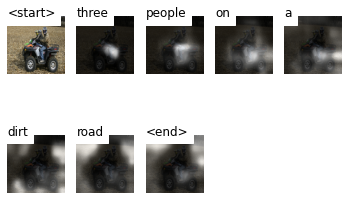

[[9.6645707e-14 8.0660383e-12 4.0672821e-10 1.0956409e-09 2.6799554e-09
  2.5266517e-10 1.8748916e-11 1.4080386e-13 1.2434834e-13 1.2240207e-13
  5.7445619e-12 1.9183516e-10 2.8039965e-10 4.6952464e-10 1.7845347e-12
  7.5633766e-09 4.4121160e-07 7.6576134e-07 1.0529027e-06 2.6848440e-07
  1.9914950e-08 2.2614485e-10 3.4399414e-10 1.7073076e-10 3.7918507e-08
  1.4947136e-06 1.8569919e-07 7.7275706e-09 1.0478344e-11 1.8148764e-07
  3.8686671e-06 5.5945143e-06 5.0037684e-06 3.0170013e-06 7.7110872e-07
  1.0731267e-08 2.0319282e-08 2.0237788e-08 6.4394917e-06 7.9116777e-05
  6.6287325e-06 8.1879215e-08 1.1960758e-11 3.4632601e-06 3.6486625e-04
  7.9731637e-04 1.2338464e-03 1.0835598e-03 3.5066632e-04 1.0205678e-04
  1.8236695e-05 8.3419684e-07 1.8652239e-05 1.0445436e-04 4.0968921e-06
  8.9618819e-09 8.4630098e-12 3.5368572e-05 2.8757496e-02 1.6711357e-01
  5.4002738e-01 2.0903796e-01 2.4649939e-02 4.7233598e-03 4.2972382e-04
  4.0212967e-06 4.1428677e-05 1.5077635e-04 2.1774413e-06 4.7030

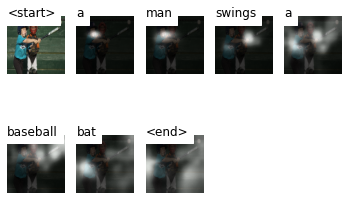

[[8.59213221e-12 6.13360144e-12 4.02055039e-12 3.29444024e-12
  3.00354945e-12 9.56788034e-12 3.95600809e-11 9.65780127e-05
  1.40386779e-04 1.74108558e-04 4.07018706e-06 2.07174566e-09
  1.15316118e-10 6.24509949e-12 1.08069170e-11 9.50737579e-12
  8.23195071e-12 5.82477400e-11 3.66480124e-10 9.28608834e-09
  1.53031010e-07 3.44065875e-02 2.88983118e-02 1.14960363e-02
  1.55850226e-04 2.67716471e-09 2.83147478e-10 2.58252014e-11
  1.43904567e-11 1.70724424e-11 1.88447417e-11 1.07663556e-09
  2.76329732e-08 2.21525147e-06 6.78105862e-05 1.12613976e-01
  2.37539560e-01 2.47543976e-01 4.74255998e-03 5.20072474e-09
  8.76760609e-10 1.50789770e-10 5.93619182e-11 7.25048563e-11
  8.80606491e-11 2.74645529e-09 4.64898662e-08 1.68735221e-06
  2.70339096e-05 8.35538059e-02 1.25507206e-01 8.25176314e-02
  1.97125904e-04 1.75441635e-08 8.95816421e-10 4.74508211e-11
  2.38362691e-10 3.27345429e-10 4.81591267e-10 5.86086468e-09
  3.95137221e-08 4.94852088e-07 4.41069915e-06 5.74268750e-04
  2.3902

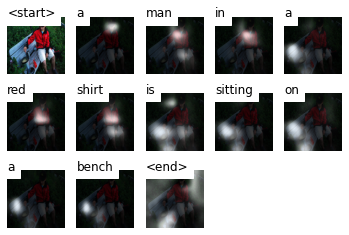

[[4.44557458e-09 1.15000565e-09 2.40257453e-10 6.16766152e-11
  1.17856783e-11 1.35258138e-10 1.09899145e-09 5.90237096e-06
  1.73289693e-04 3.97728290e-03 1.56340760e-03 4.09072905e-04
  1.32513887e-05 2.87814856e-07 3.36044054e-10 1.55411198e-10
  6.46788456e-11 1.15291936e-10 2.11083040e-10 1.13626297e-09
  3.26632765e-09 3.76497269e-06 1.74666304e-04 6.66029518e-03
  9.84817510e-04 8.78431820e-05 1.17908803e-06 1.85538145e-08
  2.79978870e-11 2.32763669e-11 2.04462194e-11 2.78390561e-10
  6.65443034e-09 1.98651708e-08 2.00677714e-08 1.74279853e-06
  9.36688884e-05 2.94881547e-03 1.52291759e-04 6.31937337e-06
  5.40963470e-08 5.01217234e-10 1.56425515e-11 8.81906007e-11
  4.35040864e-10 5.19505988e-07 4.57016213e-05 4.68255785e-05
  3.43160027e-05 4.77405138e-07 2.40847498e-06 1.41044702e-05
  2.05951983e-06 3.12596512e-07 8.45627568e-09 2.04106163e-10
  9.39313731e-12 3.88976379e-10 1.46450061e-08 1.00863428e-04
  4.82654944e-03 5.79684926e-03 1.93374208e-03 1.16899706e-07
  5.2186

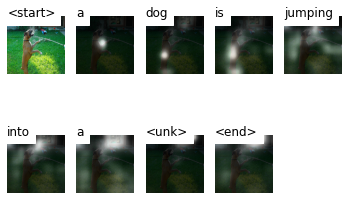

[[2.8315399e-12 6.2047503e-12 1.2841041e-11 3.0463011e-11 6.3889415e-11
  7.1143915e-12 7.3849358e-13 1.3311317e-12 4.1510228e-12 1.2371056e-11
  5.7509390e-11 2.9885500e-10 4.0117959e-10 4.1482728e-10 9.9656533e-12
  3.4961436e-09 4.8320919e-07 2.4865605e-07 1.1646654e-07 1.2011853e-09
  4.0755593e-12 2.1498124e-12 7.4309595e-12 2.5925420e-11 8.5260458e-11
  2.7962868e-10 5.5370336e-10 8.4487678e-10 2.8833658e-11 1.1103001e-06
  2.8389279e-04 8.5835483e-05 1.2431066e-05 8.3650264e-08 2.2947193e-11
  3.3990343e-12 1.3360109e-11 5.2938012e-11 1.1738831e-10 2.5707397e-10
  7.3206596e-10 1.6064166e-09 4.6267153e-11 8.9338914e-07 1.5813464e-04
  4.2941840e-05 8.4057237e-06 2.3732221e-07 7.5568468e-10 1.0353694e-10
  1.4379672e-10 1.9949047e-10 1.8970346e-10 1.7781876e-10 3.5645875e-10
  6.1283417e-10 8.0879102e-11 5.1967203e-07 5.1243318e-05 9.9988038e-06
  1.3783871e-06 4.0651122e-07 1.7893182e-08 2.9396661e-09 1.4475277e-09
  7.5022022e-10 3.0761149e-10 1.2437261e-10 1.5444948e-10 1.8787

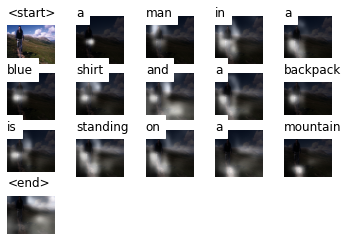

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
from skimage.io import imread
from sklearn.externals._pilutil import imresize
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):
    """
    Reads an image and captions it with beam search.

    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """

    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = imresize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)
        print(alpha.detach().cpu().numpy())

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)


        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)
        #print(scores)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)
        # print(top_k_scores)
        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)
        prev_word_inds = prev_word_inds.type(torch.LongTensor)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas


def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):
    """
    Visualizes caption with weights at every word.

    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)
    print(seq)
    words = [rev_word_map[ind] for ind in seq]
    print(" ".join(words))
    # plt.imshow(image)

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()


if __name__ == '__main__':
    # parser = argparse.ArgumentParser(description='Show, Attend, and Tell - Tutorial - Generate Caption')

    # parser.add_argument('--img', '-i', help='path to image')
    # parser.add_argument('--model', '-m', help='path to model')
    # parser.add_argument('--word_map', '-wm', help='path to word map JSON')
    # parser.add_argument('--beam_size', '-b', default=5, type=int, help='beam size for beam search')
    # parser.add_argument('--dont_smooth', dest='smooth', action='store_false', help='do not smooth alpha overlay')

    # args = parser.parse_args()

    # Load model
    checkpoint = torch.load(checkpoint_file, map_location=str(device))
    decoder = checkpoint['decoder']
    decoder = decoder.to(device)
    decoder.eval()
    encoder = checkpoint['encoder']
    encoder = encoder.to(device)
    encoder.eval()

    # Load word map (word2ix)
    with open(word_map_file, 'r') as j:
        word_map = json.load(j)
    rev_word_map = {v: k for k, v in word_map.items()}  # ix2word
    # print(rev_word_map)
    img_list = ["/content/drive/MyDrive/DL_assignment/assignment_4/Q1/images/109823394_83fcb735e1.jpg",
                "/content/drive/MyDrive/DL_assignment/assignment_4/Q1/images/141139674_246c0f90a1.jpg",
                "/content/drive/MyDrive/DL_assignment/assignment_4/Q1/images/35506150_cbdb630f4f.jpg",
                "/content/drive/MyDrive/DL_assignment/assignment_4/Q1/images/44856031_0d82c2c7d1.jpg",
                "/content/drive/MyDrive/DL_assignment/assignment_4/Q1/images/95728660_d47de66544.jpg"]
    for img in img_list:
    # Encode, decode with attention and beam search
      seq, alphas = caption_image_beam_search(encoder, decoder, img, word_map, 1)
      alphas = torch.FloatTensor(alphas)

      # Visualize caption and attention of best sequence
      visualize_att(img, seq, alphas, rev_word_map, 'smooth')


In [ ]:
vocab_size

2633

# LAB: Interactive Attention

Paper: https://arxiv.org/pdf/1709.00893.pdf

Dataset: https://drive.google.com/file/d/1tEtinCF8XZzuDvokD4DzgPS2Asyx7e3p/view

Implement the paper: Interactive Attention Networks for Aspect-Level Sentiment Classification using
this dataset. You can find the details of the dataset here. Train two models for each domain (Laptop and
Restaurant) - one with the interactive attention and another without any attention mechanism
(concatenate the pooled vector directly and predict the sentiment). Use GloVe embeddings.


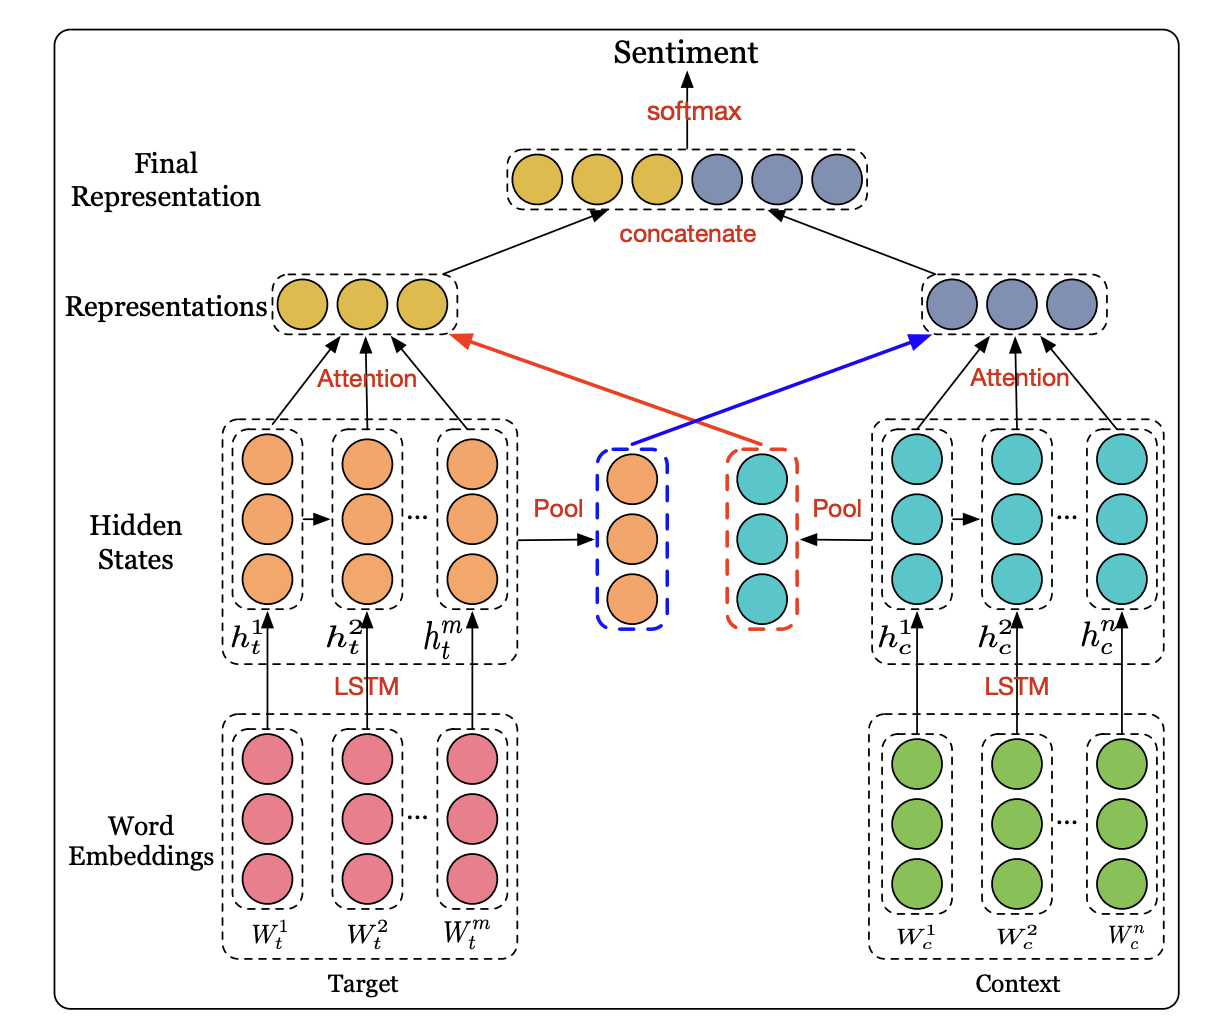